By using online retail sample data, we try to make segmentation of customer using RFM (Recency, Frequency, Monetary) analysis.

First of all, let's import the source data.

In [1]:
from google.colab import drive 
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
print(sns.__version__)


0.9.0


In [6]:
data_path = 'gdrive/My Drive/Colab Notebooks/CustSeg_RFM/Online Retail.xlsx'

df = pd.read_excel(data_path)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [50]:
# take only non-null data
df_nnull = df[pd.notnull(df['CustomerID'])]
df_nnull.shape

(406829, 8)

In [51]:
df_nnull.describe()

,Quantity,UnitPrice,CustomerID
count,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,15287.690570
std,248.693370,69.315162,1713.600303
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13953.000000
50%,5.000000,1.950000,15152.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [81]:
# remove duplicates since it will skew our analysis
filtered_df = df_nnull.drop_duplicates()
filtered_df.shape

(401604, 8)

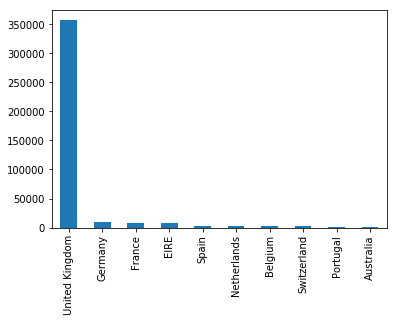

In [84]:
# now, we are moving to analysis
# first thing to do is checking top 10 countries
filtered_df['Country'].value_counts()[:10].plot(kind = 'bar')

In [86]:
# we decide to take only UK data to be analyzed
uk_data = filtered_df[filtered_df['Country'] == 'United Kingdom']
uk_data.shape

(356728, 8)

In [89]:
uk_data.info() # no missing values found here

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356728 entries, 0 to 541893
Data columns (total 8 columns):
InvoiceNo      356728 non-null object
StockCode      356728 non-null object
Description    356728 non-null object
Quantity       356728 non-null int64
InvoiceDate    356728 non-null datetime64[ns]
UnitPrice      356728 non-null float64
CustomerID     356728 non-null float64
Country        356728 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 24.5+ MB


In [92]:
uk_data.describe()  # found that quantity has minus value. so we will remove it

,Quantity,UnitPrice,CustomerID
count,356728.000000,356728.000000,356728.000000
mean,11.198644,3.268255,15543.795284
std,264.998044,71.162330,1594.286219
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,14191.000000
50%,4.000000,1.950000,15513.000000
75%,12.000000,3.750000,16931.000000
max,80995.000000,38970.000000,18287.000000


In [93]:
uk_data = uk_data[uk_data['Quantity']>0]
uk_data.describe()

,Quantity,UnitPrice,CustomerID
count,349227.000000,349227.000000,349227.000000
mean,12.181295,2.972124,15548.333625
std,191.797470,17.990307,1594.403077
min,1.000000,0.000000,12346.000000
25%,2.000000,1.250000,14191.000000
50%,4.000000,1.950000,15518.000000
75%,12.000000,3.750000,16931.000000
max,80995.000000,8142.750000,18287.000000


In [100]:
print('All columns in the data: ',list(uk_data.columns))
needed = ['InvoiceNo','Quantity', 'InvoiceDate', 'UnitPrice','CustomerID']
print('Columns needed for RFM analysis: ',needed)

All columns in the data:  ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']
Columns needed for RFM analysis:  ['InvoiceNo', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID']


In [103]:
uk_data_final = uk_data[needed]
uk_data_final['TotalPrice'] = uk_data_final['Quantity'] * uk_data_final['UnitPrice']
uk_data_final.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,InvoiceNo,Quantity,InvoiceDate,UnitPrice,CustomerID,TotalPrice
0,536365,6,2010-12-01 08:26:00,2.55,17850.0,15.30
1,536365,6,2010-12-01 08:26:00,3.39,17850.0,20.34
2,536365,8,2010-12-01 08:26:00,2.75,17850.0,22.00
3,536365,6,2010-12-01 08:26:00,3.39,17850.0,20.34
4,536365,6,2010-12-01 08:26:00,3.39,17850.0,20.34


In [105]:
uk_data_final['InvoiceDate'].min() , uk_data_final['InvoiceDate'].max()

(Timestamp('2010-12-01 08:26:00'), Timestamp('2011-12-09 12:49:00'))

In [110]:
import datetime as dt
present = dt.datetime(2019,5,25)
# convert invoicedate datatype
uk_data_final['InvoiceDate'] = pd.to_datetime(uk_data_final['InvoiceDate'])
uk_data_final.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,InvoiceNo,Quantity,InvoiceDate,UnitPrice,CustomerID,TotalPrice
0,536365,6,2010-12-01 08:26:00,2.55,17850.0,15.30
1,536365,6,2010-12-01 08:26:00,3.39,17850.0,20.34
2,536365,8,2010-12-01 08:26:00,2.75,17850.0,22.00
3,536365,6,2010-12-01 08:26:00,3.39,17850.0,20.34
4,536365,6,2010-12-01 08:26:00,3.39,17850.0,20.34


In [118]:
uk_data_final.shape

(349227, 6)

# RFM Analysis

In [0]:
rfm = uk_data_final.groupby('CustomerID').agg({'InvoiceDate': lambda date: (present - date.max()).days, # took max date of purchase for each customerID (recency)
                                              'InvoiceNo': lambda num: len(num),  # same as uk_data_final.groupby('CustomerID').count() (frequency)
                                              'TotalPrice': lambda price: price.sum()})  # sum all purchase of each customerID (monetary)

In [122]:
rfm.columns

Index(['InvoiceDate', 'InvoiceNo', 'TotalPrice'], dtype='object')

In [126]:
# change column name
rfm.columns = ['recency','frequency','monetary']
print(rfm.head())
rfm.info()


            recency  frequency  monetary
CustomerID                              
12346.0        3048          1  77183.60
12747.0        2725        103   4196.01
12748.0        2723       4413  33053.19
12749.0        2726        199   4090.88
12820.0        2726         59    942.34
<class 'pandas.core.frame.DataFrame'>
Float64Index: 3921 entries, 12346.0 to 18287.0
Data columns (total 3 columns):
recency      3921 non-null int64
frequency    3921 non-null int64
monetary     3921 non-null float64
dtypes: float64(1), int64(2)
memory usage: 122.5 KB


top consumers = low recency, high frequency, high monetary

In [130]:
# quantiles of RFM values
# using qcut()

rfm['r_quartile'] = pd.qcut(rfm['recency'], 4, ['1','2','3','4'])
rfm['f_quartile'] = pd.qcut(rfm['frequency'], 4, ['4','3','2','1'])
rfm['m_quartile'] = pd.qcut(rfm['monetary'], 4, ['4','3','2','1'])

rfm.head()

,recency,frequency,monetary,r_quartiles,f_quartiles,m_quartiles,r_quartile,f_quartile,m_quartile
CustomerID,,,,,,,,,
12346.0,3048,1,77183.60,4,4,1,4,4,1
12747.0,2725,103,4196.01,1,1,1,1,1,1
12748.0,2723,4413,33053.19,1,1,1,1,1,1
12749.0,2726,199,4090.88,1,1,1,1,1,1
12820.0,2726,59,942.34,1,2,2,1,2,2


In [131]:
# add rfm score column
rfm['RFM_score'] = rfm['r_quartile'].astype('str') + rfm['f_quartile'].astype('str') + rfm['m_quartile'].astype('str')
rfm.head()

,recency,frequency,monetary,r_quartiles,f_quartiles,m_quartiles,r_quartile,f_quartile,m_quartile,RFM_score
CustomerID,,,,,,,,,,
12346.0,3048,1,77183.60,4,4,1,4,4,1,441
12747.0,2725,103,4196.01,1,1,1,1,1,1,111
12748.0,2723,4413,33053.19,1,1,1,1,1,1,111
12749.0,2726,199,4090.88,1,1,1,1,1,1,111
12820.0,2726,59,942.34,1,2,2,1,2,2,122


In [143]:
unique_RFM_score = list(rfm['RFM_score'].unique())
print('There are '+ str(len(unique_RFM_score)) + ' RFM scores / segments') 

There are 61 RFM scores / segments


In [141]:
rfm[rfm['RFM_score'] == '111']

,recency,frequency,monetary,r_quartiles,f_quartiles,m_quartiles,r_quartile,f_quartile,m_quartile,RFM_score
CustomerID,,,,,,,,,,
12747.0,2725,103,4196.01,1,1,1,1,1,1,111
12748.0,2723,4413,33053.19,1,1,1,1,1,1,111
12749.0,2726,199,4090.88,1,1,1,1,1,1,111
12839.0,2725,314,5591.42,1,1,1,1,1,1,111
12841.0,2727,414,3991.58,1,1,1,1,1,1,111
12856.0,2730,311,2170.78,1,1,1,1,1,1,111
12901.0,2731,116,17654.54,1,1,1,1,1,1,111
12921.0,2732,720,16587.09,1,1,1,1,1,1,111
12935.0,2725,129,2160.70,1,1,1,1,1,1,111
